<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 ARIMA section
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing
For every stock or ETF being analysed, we chose to create a continuous data frame by choosing to include the average of the daily high and low as the constant day to day price between opening and closing. We made this decision because of the appropriate statisical representation the mean has of the high and low prices every day.

In [37]:
import pandas as pd
#here is a demonstration of preprocessing done on the S&P500 ETF
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
def preprocessing_function(data):
  # Create empty lists to store the new data
  dates = []
  prices = []
  price_types = []

  # Iterate through the DataFrame
  for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    high_price = row['High']
    low_price = row['Low']
    close_price = row['Close']

    # Append the data to the lists
    dates.extend([date] * 4)  # Repeat the date 4 times
    prices.extend([open_price, high_price, low_price, close_price])
    price_types.extend(['open', 'high', 'low', 'close'])

  # Create a new DataFrame
  data = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

  grouped = data.groupby(['Date', 'Type of Price'])

  # Calculate the average price for each date and type
  avg_prices = grouped['Price'].mean().reset_index()

  # Create a dictionary to store the average high and low prices for each date
  avg_high_low = {}

  # Iterate through the average prices
  for index, row in avg_prices.iterrows():
    date = row['Date']
    price_type = row['Type of Price']
    price = row['Price']

    if date not in avg_high_low:
      avg_high_low[date] = {}

    if price_type == 'high' or price_type == 'low':
      avg_high_low[date][price_type] = price

  # Iterate through the DataFrame and replace high and low prices with the average
  for index, row in data.iterrows():
    date = row['Date']
    price_type = row['Type of Price']

    if price_type == 'high' or price_type == 'low' and date in avg_high_low:
      data.loc[index, 'Price'] = avg_high_low[date][price_type]

  # Create a new DataFrame to store the modified data
  new_data = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

  # Iterate through the DataFrame
  i = 0
  while i < len(data):
    row = data.iloc[i]
    if row['Type of Price'] == 'high':
      # Check if the next row exists and is 'low'
      if i + 1 < len(data) and data.iloc[i + 1]['Type of Price'] == 'low':
        # Calculate the average of the high and low prices
        average_price = (row['Price'] + data.iloc[i + 1]['Price']) / 2
        # Add a new row with the average price and label 'average'
        new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
        i += 2  # Skip the next row (low)
      else:
        # If the next row is not 'low', keep the current row as it is
        new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
        i += 1
    else:
      # If the current row is not 'high', keep it as it is
      new_data = pd.concat([new_data, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  return new_data
sp500=preprocessing_function(sp500)
sp500_pivot = sp500.pivot(index='Date', columns='Type of Price', values='Price')
sp500_pivot.reset_index(inplace=True)
sp500_pivot

Type of Price,Date,average,close,open
0,2005-02-25,105.340,105.79,104.77
1,2005-02-28,105.120,105.08,105.55
2,2005-03-01,105.545,105.62,105.22
3,2005-03-02,105.660,105.57,105.21
4,2005-03-03,105.675,105.61,105.99
...,...,...,...,...
3196,2017-11-06,258.610,258.85,258.30
3197,2017-11-07,258.730,258.67,258.97
3198,2017-11-08,258.685,259.11,258.47
3199,2017-11-09,257.375,258.17,257.73


## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select models appropriate for the time series context.
* Compare between model types and ascertain the best model for predicting prices based on a standardised set of metrics.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

#### Model selection process
The main process applied particularly to the models designated for handling time series data such as ARIMA and ARCH during selection will be as follows:
* Cross validate the model over hyperparameter space
* Fit the model selected from the cross validation process
* Conduct one or multiple hypothesis tests to discover if the model has a good fit to the data or needs improvements.

In [14]:
#perform time series splitting (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
def split_data(data,proportion):
  train_size=int(len(data)*proportion)
  data_train = data[:train_size]
  data_test = data[train_size:]
  return data_train,data_test

Now we will start using time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices.

### (Seasonal) ARIMA approach

ARIMA models are typically the first type of model we consider when trying to model time series data. ARIMA is modelled after the following equation:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where:

$$
\Delta^d Y_t = (1 - B)^d Y_t
$$

and

$$
\epsilon_t \sim \text{white noise}
$$

Firstly, we apply normal ARIMA methods. ARIMA models only work effectively against stationary data. Our data is not staitonary. The evidence against stationarility on our data set can be shown through a p test. We use an Augmented Dickey Fuller hypothesis test for this. In the ADF test, here are the simplified hypotheses for our context.

Null hypothesis: data is not stationary

Alternative hypothesis: data is stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using ADF test
result = adfuller(sp500_pivot['average'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: 1.4394553962415115
p-value: 0.9972862135344689


As expected, there is overwhelming evidence based on the p-value, that the data is not stationary. To account for the non-stationary nature of our data, we apply a differencing transformation, that is we predict the differences or volatility in stock prices rather than the actual stock price itself so the data remains stationary.

In [16]:
#Applied differencing transformation to make data stationary
for column in ['open', 'average','close']:
  sp500_pivot[f'{column}_diff'] = sp500_pivot[column].diff().fillna(0)


We now visualise both the differences and the actual price side by side to see the effect of the transformation.

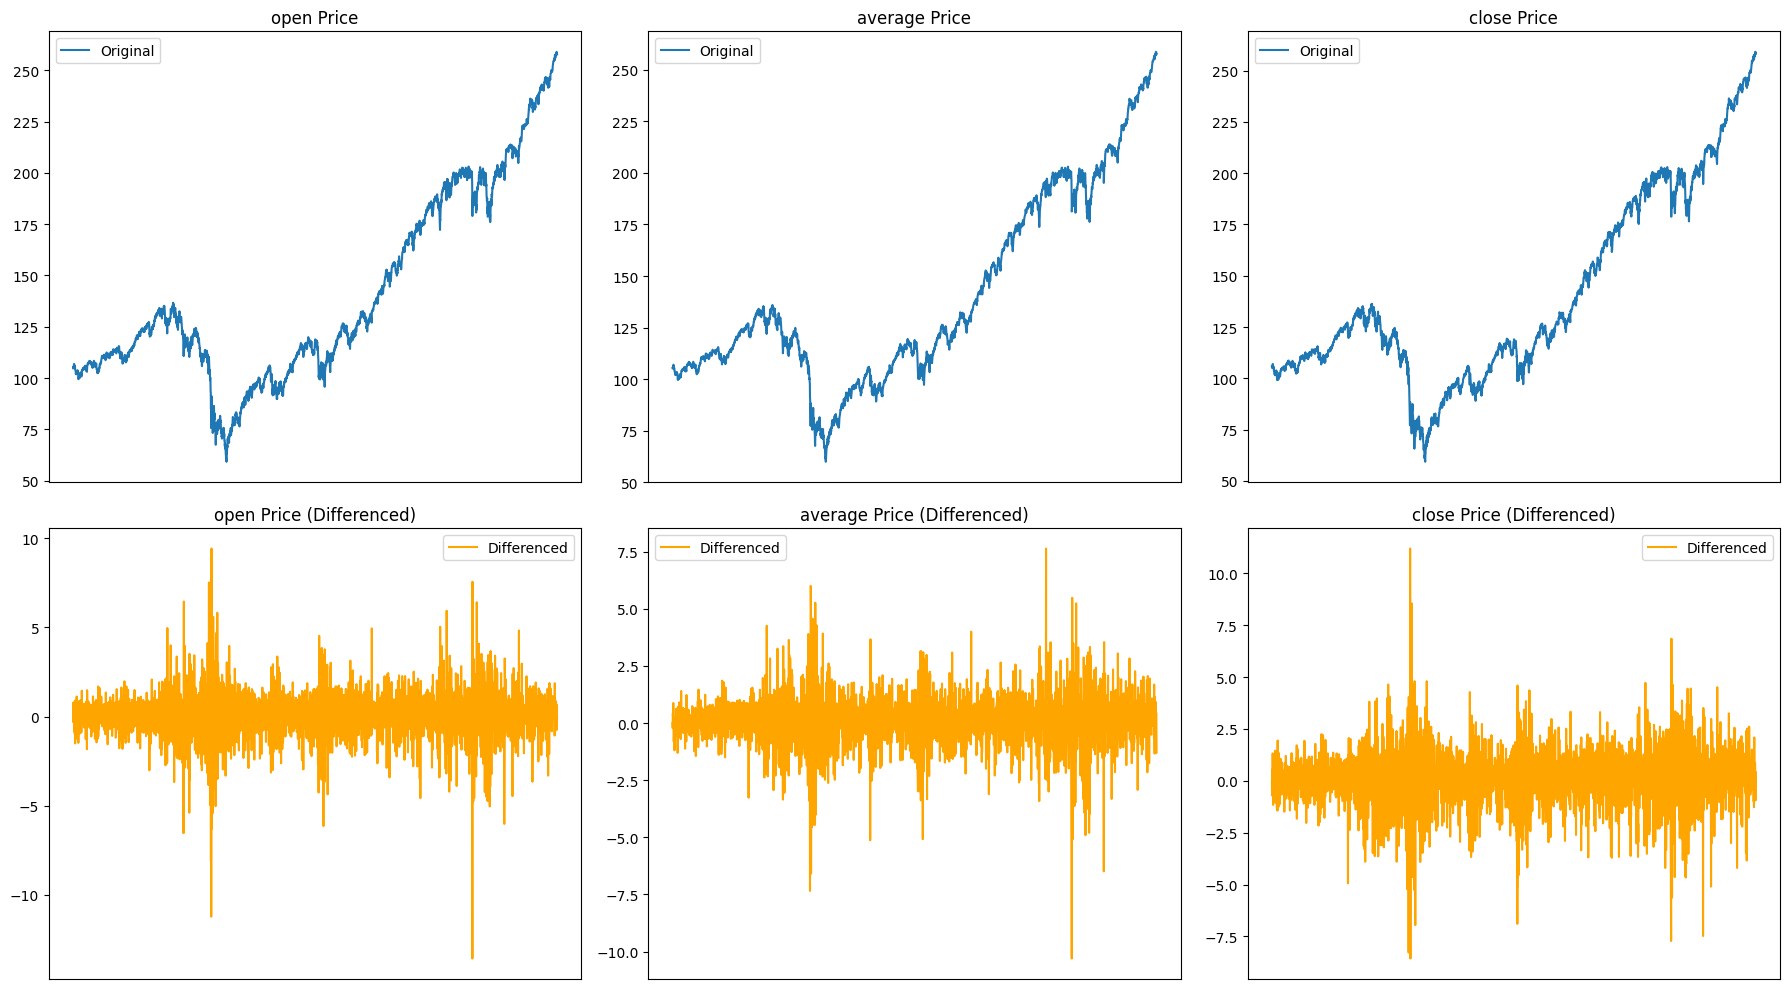

In [17]:
# Assuming sp500_pivot has columns: 'Date', 'Opening', 'Average', 'Closing',
# 'Opening_Diff', 'Average_Diff', 'Closing_Diff'

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# 1. Extract unique years, handling 'yy-mm-dd' format
years_in_data = pd.to_datetime(sp500_pivot['Date'], format='%Y-%m-%d').dt.year.unique()

# 2. Create custom tick locations using years_in_data
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)

# 3. Iterate through subplots and apply custom ticks and labels
for i in range(3):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['open', 'average', 'close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(sp500_pivot['Date'], sp500_pivot[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(sp500_pivot['Date'], sp500_pivot[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [18]:
# Redo check for stationarity using ADF test on differenced data
result = adfuller(sp500_pivot['close_diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: -12.489142144865175
p-value: 2.972267302768441e-23


According to the hypothesis test, there is strong evidence against the null so we reject the hypothesis that the data is not stationary. This is the desired outcome and now we start testing an ARIMA model to compare predicted and true volatility.

In [19]:
#note that we had to split data after the transformation because this is unlike normalisation
#we are now judging volatility which is completely different from the actual stock price
sp500_train,sp500_test=split_data(sp500_pivot,0.8)
#use the opening and average differences as feature variables
#and closing differences as the target because we want to predict closing prices
#since they are considered the "latest" most current state of prices we have before
#the new day arrives
X_train,X_test=sp500_train[['open_diff','average_diff']],sp500_test[['open_diff','average_diff']]
y_train,y_test=sp500_train['close_diff'],sp500_test['close_diff']

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [21]:
def evaluate_arima_model(X_train, y_train, X_test, y_test, order):
  """Fits an ARIMA model and returns predictions."""
  try:
    # Create and fit the ARIMA model on the training data
    model = ARIMA(y_train, exog=X_train, order=order)  # Include exog for features
    model_fit = model.fit()

    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions
    rmse = mean_squared_error(y_test, predictions, squared=False)  # Calculate RMSE

    return order, rmse  # Return order and RMSE
  except Exception as e:
    print(f"Error with order {order}: {e}")  # Print error message
    return None  # Return None for failed configurations

def grid_search_arima_parallel(X_train, y_train, p_values, d_values, q_values,n_jobs, n_splits):
    """
    Performs a grid search for ARIMA model hyperparameters using parallel computing.

    Args:
        X_train (pd.DataFrame): Features for training.
        y_train (pd.Series): Target variable for training.
        p_values (list): List of values for the AR order (p).
        d_values (list): List of values for the differencing order (d).
        q_values (list): List of values for the MA order (q).
        n_jobs (int): Number of CPU cores to use for parallel processing (-1 for all cores).
        n_splits (int): Number of splits for time series cross-validation.

    Returns:
        tuple: Best ARIMA order and its corresponding RMSE.
    """

    best_order = None
    best_rmse = float('inf')
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create a list of all hyperparameter combinations
    order_param_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    # sorder_param_combinations = [(P, D, Q,s) for P in P_values for D in D_values for Q in Q_values]

    # Evaluate all model configurations in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_arima_model)(
            X_train.iloc[train_idx],  # Features for training split
            y_train.iloc[train_idx],  # Target for training split
            X_train.iloc[validate_idx],  # Features for validation split
            y_train.iloc[validate_idx],  # Target for validation split
            order
        )
        for order in order_param_combinations
        # for sorder in sorder_param_combinations
        for train_idx, validate_idx in tscv.split(X_train)  # Split based on X_train index
    )

    # Filter out failed configurations and find the best model
    valid_results = [result for result in results if result is not None]
    print(valid_results)
    if valid_results:
        best_order, best_rmse = min(valid_results, key=lambda x: x[1])

    return best_order, best_rmse

In [22]:
#cross validate
grid_search_arima_parallel(
    X_train=X_train,
    y_train=y_train,
    p_values=range(3),
    d_values=range(3),
    q_values=range(3),
    n_jobs=-1,
    n_splits=3,
)

[((0, 0, 0), 1.169632279783436), ((0, 0, 0), 0.7583846868984087), ((0, 0, 0), 0.6599102332274238), ((0, 0, 1), 1.1756100511245133), ((0, 0, 1), 0.7659445883676663), ((0, 0, 1), 0.6808195014031997), ((0, 0, 2), 1.1752027719326494), ((0, 0, 2), 0.7657117544139683), ((0, 0, 2), 0.6805158443634322), ((0, 1, 0), 1.2740913061563055), ((0, 1, 0), 0.8015803965208509), ((0, 1, 0), 0.7644904656401532), ((0, 1, 1), 1.1696349634588712), ((0, 1, 1), 0.758382727885514), ((0, 1, 1), 0.6599130451611029), ((0, 1, 2), 1.1752401704175948), ((0, 1, 2), 0.7660684072799959), ((0, 1, 2), 0.6808210702967418), ((0, 2, 0), 216.89884482405733), ((0, 2, 0), 314.83361639129294), ((0, 2, 0), 4.017233054432836), ((0, 2, 1), 1.3295917445956595), ((0, 2, 1), 0.8120681254277912), ((0, 2, 1), 0.7940440920757621), ((0, 2, 2), 18.268863043213273), ((0, 2, 2), 0.7941121638339593), ((0, 2, 2), 0.8710904060798945), ((1, 0, 0), 1.1690070419817513), ((1, 0, 0), 0.7590055938543807), ((1, 0, 0), 0.6678072074005896), ((1, 0, 1), 

((0, 0, 0), 0.6599102332274238)

RMSE: 0.781644896215472
MAE: 0.5183603929140638
MSE: 0.6109687437796959


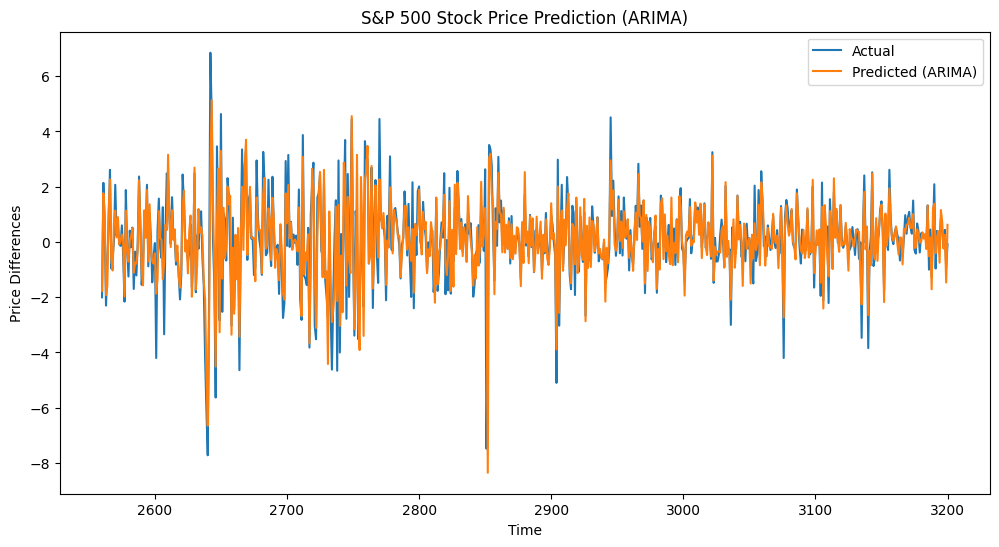

In [30]:
model = ARIMA(y_train, exog=X_train, order=(0,0,0))  # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(sp500_test['close_diff'], predictions, squared=False)
mae = mean_absolute_error(sp500_test['close_diff'], predictions)
mse = mean_squared_error(sp500_test['close_diff'], predictions)
mape = mean_absolute_percentage_error(sp500_test['close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['close_diff'], label='Actual')
plt.plot(predictions, label='Predicted (ARIMA)')
plt.title('S&P 500 Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

We interpret these results as follows: notice that the RMSE is higher than the MSE because the errors are relatively small. This is expected since the data has been differenced to account for non-stationarility. Furthermore, because most of the model's errors are relatively small in magnitude, the model is sensitive to outliers. From a non-technical perspective, this model can perform well when unpredictably extreme jumps or drops in stock prices are rare because errors when calculating the next day's stock price is low when there isn't any extremities. To partially account for extreme changes, indirect regularisation can be applied however, it is unconventional to do so on an ARIMA model. The simplest solution would be to remove outliers but this data loss would mean that we can only predict present stock prices in a market with low volatility. Next we 'reverse' our differencing transformation to make it easier to compare the true stock price and predicted stock price rather than the predicted and true volatility.

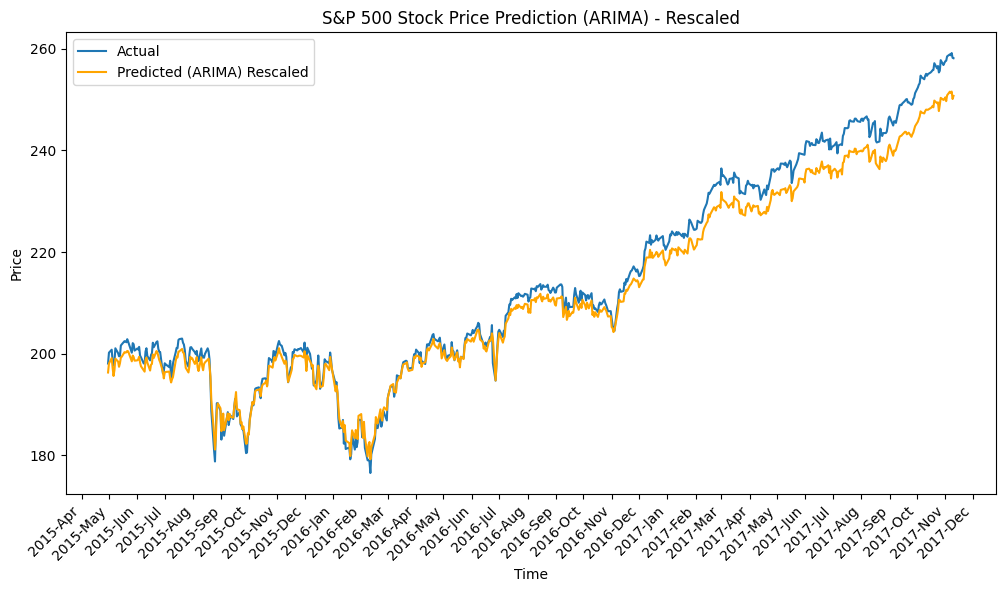

Rescaled RMSE: 3.363028315261736
Rescaled MAE: 2.6913179534352505
Rescaled MSE: 11.30995944925219
Rescaled MAPE: 0.01187192576691692


In [41]:
# Assuming 'predictions' contains the predicted price differences and 'sp500_test' has the original prices and dates

# Rescale the differenced predictions back to the original price scale
predictions_rescaled = sp500_test['close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Date'], sp500_test['close'], label='Actual')
plt.plot(sp500_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('S&P 500 Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
sp500_test['Date'] = pd.to_datetime(sp500_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(sp500_test['close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(sp500_test['close'], predictions_rescaled)
mse_rescaled = mean_squared_error(sp500_test['close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(sp500_test['close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

As observed, the model performs well during some segments and during others, not so well. We hypothesise that poor performance is attributed to the natural change in dynamics of the stock price over time. What this means is that the patterns in the stock price begin to evolve over time and slowly become unfamiliar to the model. For example, from a visual standpoint, as the stock prices begin to hike, the gap between the true and predicted prices begin to widen. The unfamiliar aspect that may not be able to be captured by the model could be the rate or magnitude at which the stock price is increasing at given that this behaviour may be unprecedented in some respects.

### (G)ARCH approach
The next model we wanted to explore was ARCH or AutoRegressive Conditional Heteroskedasticity. It is a well-known technique to use when modelling financial returns on an investment. An ARCH model is parameterised as follows:

Let  $y_t$  be a time series that is modeled as:

$$y_t = \mu + \epsilon_t$$

where:

$\mu$  is the mean,
$\epsilon_t$  is the error term, which represents the random changes at time t.

The error term  $\epsilon_t$  is assumed to have the following properties:

* $\epsilon_t$ = $\sigma_t z_t$
* $z_t$  is a white noise process with mean zero and variance 1, i.e.,  $z_t \sim N(0, 1)$ .
$\sigma_t^2$  is the conditional variance at time t.

The conditional variance is calculated as follows:

$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_q \epsilon_{t-q}^2$

where $\alpha_i$ is a positive weight placed on each term, $\epsilon_{t}$

The heteroskedacity property of the model (the ability to predict changes in error over time) allows for the measurement of volatility. A generalised ARCH adds the element of conditonal variance of the past error term to the model. This is particularly useful in our context because we are under the assumption that historical data (past prices) has a causal effect on predicted prices. It is VERY important to note that GARCH predicts the DIFFERENCE or change in stock prices, not the stock price itself.

However, after debugging failures, we chose not to explore it further. Instead some literature indicates the feasibility of autoregressive regression models on our data. See links below.

Investopedia. (2020). Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) Definition. Investopedia. https://www.investopedia.com/terms/g/garch.asp
‌

Fryzlewicz, P. (2007). Lecture notes: Financial time series, ARCH and GARCH models. http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf



In [39]:
aapl=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/aapl.us.txt')

In [40]:
aapl

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
...,...,...,...,...,...,...,...
8359,2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0
8360,2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0
8361,2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0
8362,2017-11-09,174.48000,175.46000,172.52000,175.25000,29533086,0
